In [1]:
git_repo = '../../..'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib

# My libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib
import simulation_lib

from scipy import spatial
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
%matplotlib inline

import time
from tqdm import tqdm

from copy import deepcopy

import numpy as np
import scipy as sp

np.random.seed(453453)

import json 


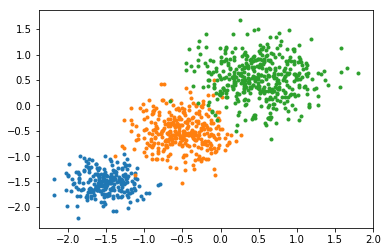

In [2]:
simulate = True
if not simulate:
    dataset_name = 'iris'
    features, iris_species = utils_lib.load_data()
    dim = features.shape[1]
else:
    # Simulate data
    dataset_name = 'simulation'

    n_obs = 1000
    dim = 2
    true_k = 3
    features, true_z, true_components, true_centroids, true_covs, true_probs = \
        simulation_lib.simulate_data(n_obs, dim, true_k, separation=0.4)

    for k in range(true_k):
        plt.plot(features[true_components == k, 0], features[true_components == k, 1], '.')

# Set up the model

In [3]:
prior_params = gmm_utils.get_default_prior_params(dim)
#prior_params['alpha'].set(8.0)
#prior_params['alpha'].set(2.0)
prior_params['alpha'].set(1.0)

prior_params['prior_gamma_df'].set(8)
prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.62)

In [4]:
k_approx = 12
gh_deg = 8
model = gmm_utils.DPGaussianMixture(
    features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

In [5]:
# run k-means init
n_kmeans_init = 50
init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)

In [9]:
t0 = time.time()
best_param, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    model.optimize_full(init_global_free_param)
t_newton = time.time() - t0

assert converged
print('Done. Converged: ', converged)

Iter: 0	 RMSE: 13.253388577020331	 Objective: 2232.5324427792184
Iter: 50	 RMSE: 14.155910220644186	 Objective: -270.38014716315365
Iter: 100	 RMSE: 14.122418316156658	 Objective: -273.64053775041134
Iter: 150	 RMSE: 14.107183144703669	 Objective: -273.64681086016105
Optimization terminated successfully.
         Current function value: -273.646811
         Iterations: 146
         Function evaluations: 160
         Gradient evaluations: 160
Iter: 160	 RMSE: 14.107184000259162	 Objective: -273.64681086080645
Optimization terminated successfully.
         Current function value: -273.646811
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Done. Converged:  True


In [10]:
kl_hessian = model.objective.fun_free_hessian(best_param)

In [11]:
fit_dict = gmm_utils.get_checkpoint_dictionary(model, kl_hessian, seed=453453)
base_alpha = model.prior_params['alpha'].get()
filename = 'ryan_{}_bnp_full_data_fit_alpha{}.json'.format(dataset_name, base_alpha)
json_output_file = os.path.join(
    git_repo,
    'BNP_sensitivity/GMM_clustering/iris_fits/',
    filename)
print('saving fit dict to ', json_output_file)
with open(json_output_file, 'w') as outfile:
    json.dump(fit_dict, outfile)


saving fit dict to  ../../../BNP_sensitivity/GMM_clustering/iris_fits/ryan_simulation_bnp_full_data_fit_alpha1.0.json
